{'000': 50852, '010': 90687, '001': 178159, '100': 198701, '110': 159851, '101': 71942, '011': 135083, '111': 114725}
Clave: 000, Posición binaria: 00
Clave: 010, Posición binaria: 01
Clave: 001, Posición binaria: 00
Clave: 100, Posición binaria: 10
Clave: 110, Posición binaria: 11
Clave: 101, Posición binaria: 10
Clave: 011, Posición binaria: 01
Clave: 111, Posición binaria: 11
Error cuadrático medio (MSE): 37.80007249110873
[[ 76  29]
 [150 226]] valor de imagen original
[[ 76.32839375  29.        ]
 [162.29196679 226.        ]] valor reconstruida


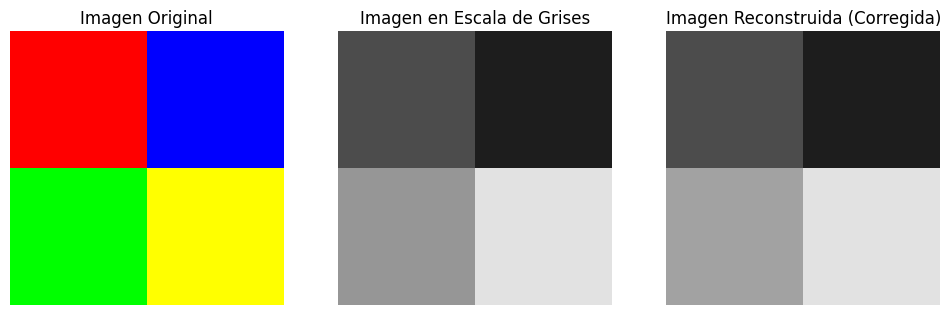

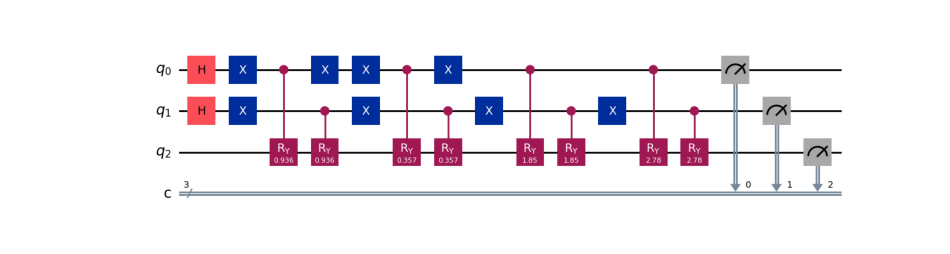

In [3]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


# Función para cargar y convertir una imagen a escala de grises
def cargarImagen(imagePath):
    imagen = Image.open(imagePath)
    imagenGris = imagen.convert('L')  # Convertir a escala de grises
    arrayImagen = np.array(imagenGris)
    return arrayImagen

# Función para codificar una imagen usando FRQI
def codificarImagenFRQI(imagen):
    numPixeles = imagen.size
    n = int(np.log2(numPixeles))

    angulos = (imagen.flatten() / 255.0) * (np.pi / 2)  # Mapeo de intensidades a ángulos

    qc = QuantumCircuit(n + 1, n + 1)

    for i in range(n):
        qc.h(i)  # Aplicar hadamard para superposición

    for i in range(numPixeles):
        binStr = format(i, f'0{n}b')
        for j, bit in enumerate(binStr):
            if bit == '0':
                qc.x(j)  # Aplicar X a los bits 0

        theta_i = angulos[i]
        qc.cry(2 * theta_i, list(range(n)), n)  # Rotar el qubit ancilla 2 por theta que se controla con la lista de n y afecta al n qubit ancilla

        for j, bit in enumerate(binStr):
            if bit == '0':
                qc.x(j)  # Revertir las puertas X aplicadas

    qc.measure(list(range(n + 1)), list(range(n + 1)))  # Medición de los qubits
    return qc

# Función para recuperar la imagen del circuito cuántico
def recuperarImagenFRQI(qc, numDisparos=1000000):
    simulador = AerSimulator()
    qcTransp = transpile(qc, simulador)
    resultado = simulador.run(qcTransp, shots=numDisparos).result()
    cuentas = resultado.get_counts()
    return cuentas

# Ajuste de la probabilidad para suavizar los extremos
def ajustarEscalado(imagenReconstruida):
    min_val = np.min(imagenReconstruida)
    max_val = np.max(imagenReconstruida)

    # Evitar un rango demasiado pequeño para que los valores no se disparen a 0 o 255
    if max_val - min_val > 0:
        imagenReconstruida = (imagenReconstruida - min_val) / (max_val - min_val) * 255
    
    # Aplicar una corrección suave para evitar valores 0 o 255 exactos
    imagenReconstruida = np.clip(imagenReconstruida, 29, 226)
    return imagenReconstruida

# Función para corregir la rotación de la imagen reconstruida
def corregirRotacion(imagenReconstruida):
    # Realizar una transposición y luego invertir verticalmente para corregir la rotación
    imagenCorregida = np.rot90(imagenReconstruida, k=-1)  # Rotar 90 grados en sentido horario
    return imagenCorregida

# Función para reconstruir la imagen con el operador de densidad y la fórmula de arccos
def reconstruirImagenCorrigiendoRotacion(cuentas, dim):
    numPixeles = dim[0] * dim[1]
    imagenReconstruida = np.zeros(numPixeles)
    totalDisparos = sum(cuentas.values())

    # Inicializar diccionario para separar cuentas de |0⟩ y |1⟩ en el qubit ancilla
    cuentas_por_pixel = {i: {'0': 0, '1': 0} for i in range(numPixeles)}

    # Llenar el diccionario con las cuentas correspondientes
    for key, value in cuentas.items():
        posicion_bin = key[:-1]  # Ignorar el último qubit (ancilla)
        posicion = int(posicion_bin, 2)  # Interpretar los bits tal cual, sin invertir
        print(f"Clave: {key}, Posición binaria: {posicion_bin}")


        ancilla = key[-1]  # Obtener el valor del qubit ancilla
        cuentas_por_pixel[posicion][ancilla] += value  # Sumar las cuentas a la posición correspondiente

    # Calcular la intensidad de cada píxel
    for posicion, probabilidades in cuentas_por_pixel.items():
        prob_0 = probabilidades['0'] / totalDisparos if probabilidades['0'] > 0 else 0
        prob_1 = probabilidades['1'] / totalDisparos if probabilidades['1'] > 0 else 0

        # Calcular la intensidad usando la fórmula basada en arccos
        if (prob_0 + prob_1) > 0:
            intensidad = np.arccos(np.sqrt(prob_0 / (prob_0 + prob_1))) * (2 * 255 / np.pi)
        else:
            intensidad = 0  # Si no hay cuentas

        imagenReconstruida[posicion] = np.clip(intensidad, 0, 255)

    # Convertir a la forma correcta (dimensión de la imagen original)
    imagenReconstruida = imagenReconstruida.reshape(dim)

    # Aplicar una rotación de 180 grados en sentido antihorario
    imagenReconstruida = np.rot90(imagenReconstruida, k=2)

    return ajustarEscalado(imagenReconstruida)

# Función para calcular el MSE entre dos imágenes
def calcularMSE(imagenOriginal, imagenReconstruida):
    # Aplanar ambas imágenes para poder comparar pixel a pixel
    original_flat = imagenOriginal.flatten()
    reconstruida_flat = imagenReconstruida.flatten()
    
    # Calcular el MSE
    mse = mean_squared_error(original_flat, reconstruida_flat)
    return mse

# Función para restar las imágenes
def restarImagenes(imagenOriginal, imagenReconstruida):
    # Restar las imágenes y retornar el resultado
    diferencia = imagenOriginal.astype(float) - imagenReconstruida.astype(float)
    return diferencia


# Función para plotear el circuito con matplotlib
def plotearCircuito(qc):
    figura_circuito = qc.draw(output='mpl')
    figura_circuito.savefig("img/circuito.png")
    img = Image.open("img/circuito.png")
    plt.figure(figsize=(12, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.show()



# Especificar la ruta de la imagen (reemplázala con tu propia ruta)
imagePath = 'img/imagen_2x2.png'  

# Cargar la imagen
imagen = cargarImagen(imagePath)

# Codificar la imagen usando FRQI
qc = codificarImagenFRQI(imagen)

# Recuperar las cuentas del circuito cuántico
cuentas = recuperarImagenFRQI(qc)
print(cuentas)

# Reconstruir la imagen con corrección de rotación
imagenReconstruidaCorregida = reconstruirImagenCorrigiendoRotacion(cuentas, imagen.shape)

#Calcular el error cuadratico medio 
mse = calcularMSE(imagen, imagenReconstruidaCorregida)
print(f'Error cuadrático medio (MSE): {mse}')

# Mostrar las imágenes
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.title('Imagen Original')
plt.imshow(np.array(Image.open(imagePath)), cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Imagen en Escala de Grises')
plt.imshow(imagen, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
valImagen = np.array(imagen)
print(valImagen, 'valor de imagen original')

plt.subplot(1, 3, 3)
plt.title('Imagen Reconstruida (Corregida)')
plt.imshow(imagenReconstruidaCorregida, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
valoRecon = np.array(imagenReconstruidaCorregida)
print(valoRecon, 'valor reconstruida')

plotearCircuito(qc)


plt.show()
